In [16]:
import dust_emissivity
from astropy import units as u
from astropy import constants as const
from matplotlib import pyplot as pl
import numpy as np
import regions
from astropy.io import fits
from astropy import wcs
from spectral_cube import SpectralCube
from astropy.table import QTable
import random as rand

In [2]:
# Field 2
pacs160 = 1293.3408711236984 * u.Jy
pacs70  = 139.69878764504287 * u.Jy
her350  = 696.3290434110337  * u.Jy
her250  = 1296.7746088093395 * u.Jy
her500  = 290.8775740884424  * u.Jy
bolo11  = 11.132808608750626 * u.Jy
atlas850= 80.42944585935663  * u.Jy
reg = regions.Regions.read('/orange/adamginsburg/cmz/g5/code/g5-field2.reg')

In [3]:
area_as = reg[0].width*reg[0].height#195.4252*u.arcsec*163.3396*u.arcsec


In [5]:
# Error bars are quadrature sum of statistical uncertainty (background noise) and inherent uncertainty due to flux calibration 
err70  = np.sqrt((0.05 * pacs70)**2 + (0.0090522 * u.Jy)**2) # Hi-GAL
err160 = np.sqrt((0.05 * pacs160)**2 + (0.022673243 * u.Jy)**2) # ---
err250 = np.sqrt((0.05 * her250)**2 + (0.10495919 * u.Jy)**2) # ---
err350 = np.sqrt((0.05 * her350)**2 + (0.10400883 * u.Jy)**2) # ---
err500 = np.sqrt((0.05 * her500)**2 + (0.095411145 * u.Jy)**2) # Hi-GAL
err850 = np.sqrt((0.15 * atlas850)**2 + (0.0022267786 * u.Jy)**2) # Atlasgal
err11  = np.sqrt((0.20 * bolo11)**2 + (0.0024273499 * u.Jy)**2) # Bolocam

In [6]:
sed = [
    (70*u.micron, pacs70, 'PACS', '70 um', err70), # pacsfn_1
    (160*u.micron, pacs160, 'PACS', '160 um', err160), # pacsfn_1
    (250*u.micron, her250, 'Herschel', '250 um', err250), # herfn_1
    (350*u.micron, her350, 'Herschel', '350 um', err350), # herfn_2
    (500*u.micron, her500, 'Herschel', '500 um', err500), # herfn_3
    (850*u.micron, atlas850, 'ATLASGAL', '850 um', err850),
    ((1.1*u.mm).to(u.micron), bolo11, 'Bolocam' ,'1.1 mm', err11) # Bolocam
]      
#((353 * u.GHz).to(u.micron, equivalencies=u.spectral()), atlas850, 'ATLASGAL', '850 um')] # ATLASGAL

In [7]:
modfit,errs = dust_emissivity.fit_sed.fit_modified_bb(xdata=u.Quantity([p[0] for p in sed]).to(u.Hz, u.spectral()),
                                        flux=u.Quantity([p[1]/area_as.to(u.sr) for p in sed]),
                                        #error=u.Quantity([p[1]*0.1/area_as.to(u.sr) for p in sed]),
                                        error=u.Quantity([p[4]/area_as.to(u.sr) for p in sed]),
                                        guesses=[15*u.K, 2, 1e18*u.cm**-2],
                                        fitter='lmfit',
                                        return_error=True
                                       )
modfit

[<Quantity 18.08840215 K>,
 1.7573612692123384,
 <Quantity 4.33752352e+21 1 / cm2>]

In [8]:
freq = (np.linspace(70, 1100, num=50) * u.micron).to(u.Hz, u.spectral())

In [9]:
du = dust_emissivity.blackbody.modified_blackbody(
    #u.Quantity([p[0] for p in sed]).to(u.Hz, u.spectral()), 
    freq,
    temperature = modfit[0], 
    beta = modfit[1], 
    column = modfit[2])

Text(0, 0.5, 'Jy')

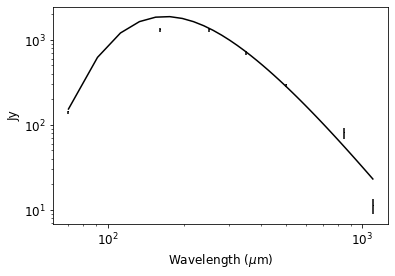

In [92]:
pl.figure(figsize=(6,4))
pl.rcParams.update({'font.size': 12})

pl.loglog(freq.to(u.micron, u.spectral()), (du*area_as).to(u.Jy), color='k')
#pl.scatter(u.Quantity([p[0] for p in sed]).to(u.micron, u.spectral()), u.Quantity([p[1] for p in sed]))#, color='blue')
pl.errorbar(x=u.Quantity([p[0] for p in sed]).to(u.micron, u.spectral()), y=u.Quantity([p[1] for p in sed]), yerr=u.Quantity([p[4] for p in sed]), fmt=',', color='k')

#pl.title('All Points')
pl.xlabel('Wavelength ($\mu$m)')
pl.ylabel('Jy')

In [104]:
num=10
randintegers = np.zeros(7*num, dtype=np.int8)

for r in range(len(randintegers)):
    randintegers[r] = random.randint(0, 6)

#randintegers.reshape((num, 7))

In [100]:
def sed_fit_boot(sed):
    modfit,errs = dust_emissivity.fit_sed.fit_modified_bb(xdata=u.Quantity([p[0] for p in sed]).to(u.Hz, u.spectral()),
                                        flux=u.Quantity([p[1]/area_as.to(u.sr) for p in sed]),
                                        #error=u.Quantity([p[1]*0.1/area_as.to(u.sr) for p in sed]),
                                        error=u.Quantity([p[4]/area_as.to(u.sr) for p in sed]),
                                        guesses=[15*u.K, 2, 1e18*u.cm**-2],
                                        fitter='lmfit',
                                        return_error=True
                                       )
    return modfit, errs

In [101]:
modfit[2].unit

Unit("1 / cm2")

(7, 4000)

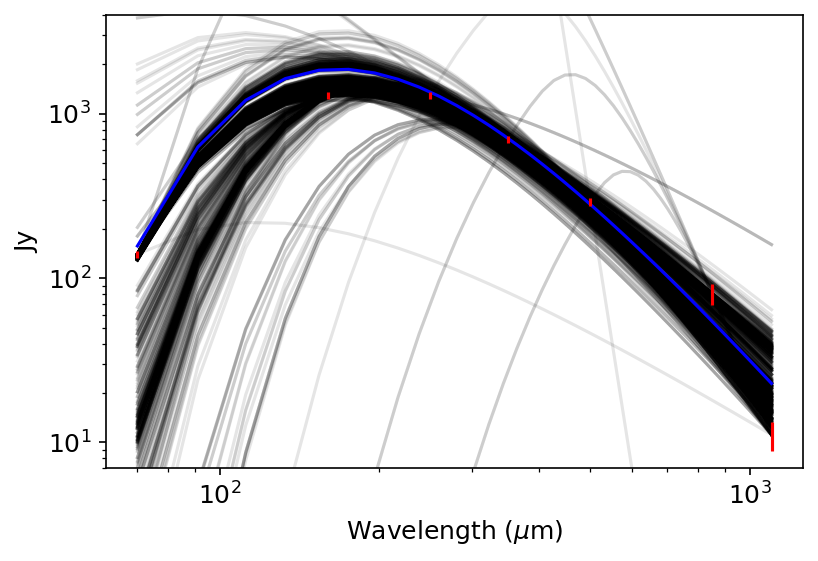

In [102]:
pl.figure(figsize=(6,4), dpi=150)
pl.rcParams.update({'font.size': 12})
temp_avg = np.zeros(num)*modfit[0].unit
beta_avg = np.zeros(num)
column_avg = np.zeros(num)*modfit[2].unit
ii = 0

for boot in randintegers.reshape((num, 7)):
    #print(boot)
    boot_sed = []
    for bb in boot:
        boot_sed.append(sed[bb])
    #print(boot_sed)
    modfit_boot, errs_boot = sed_fit_boot(boot_sed)
    du = dust_emissivity.blackbody.modified_blackbody(
        freq,
        temperature = modfit_boot[0], 
        beta = modfit_boot[1], 
        column = modfit_boot[2]
    )
    temp_avg[ii] = modfit_boot[0]#0*modfit[0].unit
    beta_avg[ii] = modfit_boot[1]#0
    column_avg[ii] = modfit_boot[2]#0*modfit[2].unit
    pl.loglog(freq.to(u.micron, u.spectral()), (du*area_as).to(u.Jy), color='k', alpha=0.1)
    #pl.scatter(u.Quantity([p[0] for p in sed]).to(u.micron, u.spectral()), u.Quantity([p[1] for p in sed]))#, color='blue')
    ii += 1

du = dust_emissivity.blackbody.modified_blackbody(
        freq,
        temperature = np.median(temp_avg), 
        beta = np.median(beta_avg), 
        column = np.median(column_avg)
    )
pl.loglog(freq.to(u.micron, u.spectral()), (du*area_as).to(u.Jy), color='blue')
pl.errorbar(x=u.Quantity([p[0] for p in sed]).to(u.micron, u.spectral()), y=u.Quantity([p[1] for p in sed]), yerr=u.Quantity([p[4] for p in sed]), fmt=',', color='red')

pl.xlabel('Wavelength ($\mu$m)')
pl.ylabel('Jy')
pl.ylim(bottom=7, top=4000)

In [103]:
print(np.median(temp_avg), np.median(beta_avg), np.median(column_avg))

17.900552001317443 K 1.8496595794832864 4.828086647261218e+21 1 / cm2
